In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

In [2]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
d = "../experiments/baseline-trinitite/"


## Motivation: Keyspace 

The ParSplice keyspace is small (numbers above bars) but must satisfy many reads as workers calculate new segments. The active keyspace is difficult to predict a priori but the optimal load balancing strategy strikes a good balance between preformance and utiization. 

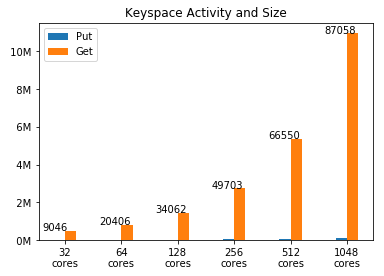

In [3]:
#Furthermore, the keypspace grows in a structured way, so we can predict the number and popularity of hot keys.
def get_perfcount(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]
    
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df

#### Figure 1
def get_rank_ops(op_mem, op_db):
    label = []
    InMemoryDB = []; WorkManager = []; PersistentDB = [];
    for run in [d+"nano-sepminima/scale-workers-1to8n/scale-workers-1-71033",
                d+"nano-sepminima/scale-workers-1to8n/scale-workers-2-71035",
                d+"nano-sepminima/scale-workers-1to8n/scale-workers-4-71036"]:
        label.append(str(int(os.path.basename(run).split('-')[2])*32) + "\ncores")    
        InMemoryDB.append(get_perfcount(op_mem, run, rank="3").tail(1)['count'])        
        WorkManager.append(get_perfcount(op_mem, run).tail(1)['count'])    
        PersistentDB.append(get_perfcount(op_db, run, rank="2").tail(1)['count'])

    label.append("256\ncores")
    df = get_perfcount(op_mem, d+"nano-sepminima/scale-mantle-workers/scale-mantle-unlimited-71705", rank="3")
    df = df[df['shift']==4200]    
    InMemoryDB.append(df['count'])
    df = get_perfcount(op_mem, d+"nano-sepminima/scale-mantle-workers/scale-mantle-unlimited-71705")
    df = df[df['shift']==4200]    
    WorkManager.append(df['count'])
    df = get_perfcount(op_db, d+"nano-sepminima/scale-mantle-workers/scale-mantle-unlimited-71705", rank="2")
    df = df[df['shift']==4200]    
    PersistentDB.append(df['count'])
    
    label.append("512\ncores")
    df = get_perfcount(op_mem, d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161", rank="3")
    df = df[df['shift']==4200]
    InMemoryDB.append(df['count'])
    df = get_perfcount(op_mem, d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161")
    df = df[df['shift']==4200]
    WorkManager.append(df['count'])
    df = get_perfcount(op_db, d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161", rank="2")
    df = df[df['shift']==4201]
    if len(df) == 0: PersistentDB.append(0)
    else: PersistentDB.append(df['count'])
        
    label.append("1048\ncores")
    df = get_perfcount(op_mem,d+"nano-sepminima/scale-keyspace-trace/scale-workers-32-71694/", rank="3")
    InMemoryDB.append(df.tail(1)['count'])
    df = get_perfcount(op_mem, d+"nano-sepminima/scale-keyspace-trace/scale-workers-32-71694/")
    df1 = get_perfcount(op_mem, d+"nano-sepminima/scale-keyspace-trace/scale-workers-32-71694/", rank="2")    
    WorkManager.append(float(df.tail(1)['count']) + float(df1.tail(1)['count']))
    df = get_perfcount(op_db, d+"nano-sepminima/scale-keyspace-trace/scale-workers-32-71694/", rank="1")
    PersistentDB.append(df.tail(1)['count'])

    return InMemoryDB, WorkManager, PersistentDB, label

fig, ax = plt.subplots(1, 1)#, figsize=(8, 3))
fig.subplots_adjust(wspace=0.25)
InMemoryDB, WorkManager, PersistentDB, label = get_rank_ops("DBMemoryPut", "LDBPut")
ax.bar(np.arange(len(WorkManager))-0.1, WorkManager, width=0.2, label="Put")
#ax[0].bar(np.arange(len(InMemoryDB))-0.1, InMemoryDB, width=0.2, label="Put")
#ax[2].bar(np.arange(len(PersistentDB))-0.1, PersistentDB, width=0.2, label="Put")

InMemoryDB, WorkManager, PersistentDB, label = get_rank_ops("DBMemoryGet", "LDBGet")
x = np.arange(len(WorkManager))+0.1
y = WorkManager
ax.bar(x, y, width=0.2, label="Get")
#ax[0].bar(np.arange(len(InMemoryDB))+0.1, InMemoryDB, width=0.2, label="Get")
#ax[2].bar(np.arange(len(PersistentDB))+0.1, PersistentDB, width=0.2, label="Get")

ax.set_title("Keyspace Activity and Size")
ax.set_xticks(range(0, len(InMemoryDB)))
ax.set_xticklabels(label)
#ax.set_ylim(0, 10*1000*1000)
ax.legend()

k = 0
for i,j in zip(x,y):
    ax.annotate(str(int(InMemoryDB[k])),xy=(i-0.5,j+0))
    k += 1

#ax[0].set_title("Keyspace Size)
#ax[0].set_ylabel("# of Operations")
#ax[0].set_xticks(range(0, len(WorkManager)))
#ax[0].set_xticklabels(label); ax[1].legend()

#ax[2].set_title("Persistent DB Node")
#ax[2].set_xticks(range(0, len(PersistentDB)))
#ax[2].set_xticklabels(label); ax[2].legend()

#ax[1].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
x = ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
#x = ax[2].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[2].get_yticks()])#
fig.savefig("../paper/figures/methodology-keyspace.png", bbox_inches='tight', dpi=400)

## Motivation: Trade-off

Figure (a): limiting the cache size hurts performance

Figure (b): the first 2 policies are static: "unlimited" grows with the keyspace and "fixed sized cache" keeps the cache at 100 keys. The "dynamic" policy switches between the two to reduce memory pressure without affecting performance.

Figure (c): the policy for (b) does not work when we change the delay.

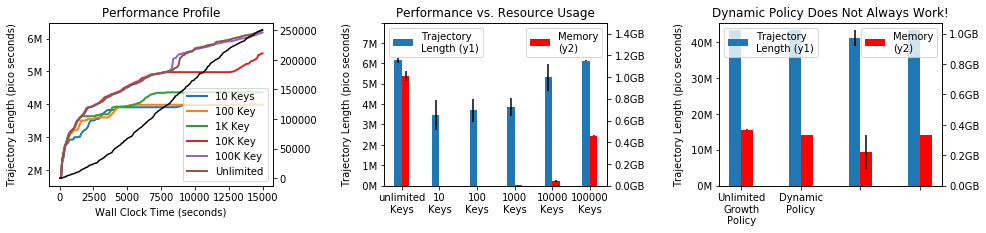

In [4]:
#The graphs below that swtiching policies helps... the hard part is predciting when to make the switch and how many keys to cache at a time! The workload is so structured; instead of spending weeks trying to tune LevelDB, can we just learn "when to change policies" and "how much we change at a time".
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()


def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.tail(1)

fig, ax = plt.subplots(1, 3, figsize=(16, 3))
fig.subplots_adjust(wspace=0.5)
plot_times(ax[0], "10 Keys", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989")
plot_times(ax[0], "100 Key", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990")
plot_times(ax[0], "1K Key",  d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991")
plot_times(ax[0], "10K Key", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004")
plot_times(ax[0], "100K Key", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")
plot_times(ax[0], "Unlimited", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000")
ax[0].legend()
ax[0].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[0].get_yticks()])

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006",
             ),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001"
             ),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"),           
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004"),               
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[2]
    if l == "8n": l = os.path.basename(run).split('-')[3]
    l += "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax[0].set_title("Performance Profile")
df = get_perfcount("DBMemoryMapSize", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax2 = ax[0].twinx()
ax2.plot(df['shift'], df['count'], color='black')  
#ax2.set_ylim(0, 30000)

ax[1].set_title("Performance vs. Resource Usage")
ax[1].bar(np.arange(len(trajs)) - 0.1, trajs, yerr=terror, width=0.2, label="Trajectory\nLength (y1)")
ax[1].set_xticks(range(0, len(trajs)))
#ax[1].set_xticklabels(["Unlimited\nGrowth\nPolicy", "Fixed Sized\nCache\nPolicy", "Double\nGrowth\nPolicy", "Dynamic\nPolicy"])
ax[1].set_xticklabels(label)
ax[1].set_ylabel("Trajectory Length (pico seconds)")
ax[1].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
ax[1].legend(loc='upper left')
ax[1].set_ylim(0, 8*1000*1000)
ax2 = ax[1].twinx()
ax2.bar(np.arange(len(memory)) + 0.1, memory, yerr=merror, width=0.2, color='r', label="Memory\n(y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.4*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])



#### Figure 3
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-unlimited-71814",
              d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-unlimited-71810"),
             (d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-10-71807",
              d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-10-71811"),
             (d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-100-71808",
              d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-100-71812"),
             (d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-100000-71809",
              d+"/nano-sepminima/scale-mantle-workers/scale-mantle-1M-100000-71813")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    label.append(os.path.basename(run).split('-')[3] + "\nKey")
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))    
ax[2].set_title("Dynamic Policy Does Not Always Work!")
ax[2].bar(np.arange(len(trajs)) - 0.1, trajs, yerr=terror, width=0.2, label="Trajectory\nLength (y1)")
ax[2].set_xticks(range(0, len(trajs)))
ax[2].set_xticklabels(label)
ax[2].set_ylabel("Trajectory Length (pico seconds)")
ax[2].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[2].get_yticks()])
ax[2].legend(loc='upper left')
#ax[2].set_ylim(0, 60*1000*1000)
ax2 = ax[2].twinx()
ax2.bar(np.arange(len(memory)) + 0.1, memory, yerr=merror, width=0.2, color='r', label="Memory\n(y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.set_xticklabels(["Unlimited\nGrowth\nPolicy", "Dynamic\nPolicy"])
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1*1024*1024*1024)
x = ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])

fig.savefig("../paper/figures/motivation-tradeoff.png", bbox_inches='tight', dpi=400)

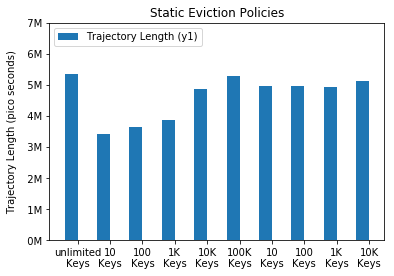

In [5]:
def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.head(int(len(df)*0.6)).tail(1)

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.head(int(len(df)*0.6)).tail(1)

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"),           
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004"),               
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72376"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72373",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")    
            ]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        #m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    #terror.append(float(np.std(t)))
    #memory.append(float(np.mean(m)))
    #merror.append(float(np.std(m)))

fig, ax = plt.subplots(1, 1)
ax.set_title("Static Eviction Policies")
#ax.bar(np.arange(len(trajs)) - 0.1, trajs, yerr=terror, width=0.2, label="Trajectory Length (y1)")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, width=0.4, label="Trajectory Length (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylabel("Trajectory Length (pico seconds)")
ax.legend(loc='upper left')
ax.set_ylim(0, 7*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
#ax2 = ax.twinx()
#ax2.bar(np.arange(len(memory)) + 0.1, memory, yerr=merror, width=0.2, color='r', label="Memory (y2)")
#ax2.set_xticks(range(0, len(memory)))
#ax2.legend(loc='upper right')
#ax2.set_ylim(0, 1.2*1024*1024*1024)
#ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])

#fig.savefig("../paper/figures/methodology-tradeoff.png", bbox_inches='tight', dpi=400)

## 4 Hour Run

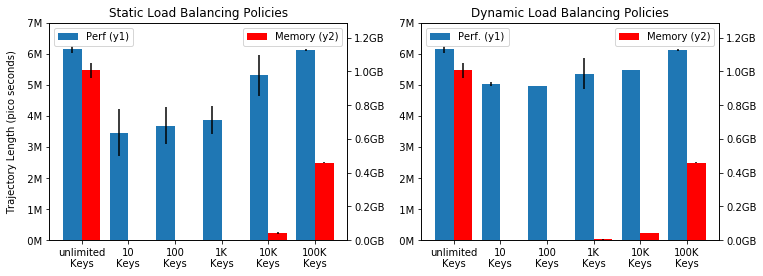

In [6]:
def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.head(int(len(df)*1)).tail(1)

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.head(int(len(df)*1)).tail(1)

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"),           
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004"),               
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

fig, axis = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.25)
ax = axis[0]
ax.set_title("Static Load Balancing Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, width=0.4, label="Perf (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylabel("Trajectory Length (pico seconds)")
ax.legend(loc='upper left')
ax.set_ylim(0, 7*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72376"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72373",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = axis[1]
ax.set_title("Dynamic Load Balancing Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, width=0.4, label="Perf. (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
#ax.set_ylabel("Trajectory Length (pico seconds)")
ax.legend(loc='upper left')
ax.set_ylim(0, 7*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])

#fig.savefig("../paper/figures/methodology-tradeoff.png", bbox_inches='tight', dpi=400)

(6000, 10000)

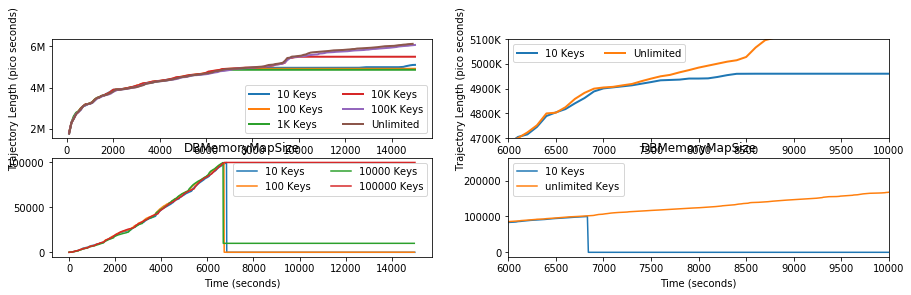

In [7]:
def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    ax.plot(df['ts'].astype(float) - shift, df['cs'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

fig, axis = plt.subplots(2, 2, figsize=(15, 4))
ax = axis[0][0]
plot_times(ax, "10 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
plot_times(ax, "100 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
plot_times(ax, "1K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378")
plot_times(ax, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")
#plot_times(ax, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72363")
plot_times(ax, "100K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
plot_times(ax, "Unlimited", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax.legend(ncol=2)
#ax.set_ylim(5*1000*1000, 6*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    if label == "":
        label = os.path.basename(results).split('-')[3] + " Keys"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend(ncol=2)
#ax.set_xlim(0, 10000)
#ax.set_ylim(4*1000*1000, 5*1000*1000)

ax = axis[1][0]
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72363")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
#ax.set_xlim(0, 10000)

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    ax.plot(df['ts'].astype(float) - shift, df['cs'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

ax = axis[0][1]
plot_times(ax, "10 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
#plot_times(ax, "100 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
#plot_times(ax, "1K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378")
#plot_times(ax, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")
#plot_times(ax, "100K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
plot_times(ax, "Unlimited", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax.legend(ncol=2)
ax.set_xlim(6000, 10000)
ax.set_ylim(4.7*1000*1000, 5.1*1000*1000)
ax.set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax.get_yticks()])

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    if label == "":
        label = os.path.basename(results).split('-')[3] + " Keys"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend()

ax = axis[1][1]
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
#plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
#plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72363")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax.set_xlim(6000, 10000)


## 2.5 Hour Run

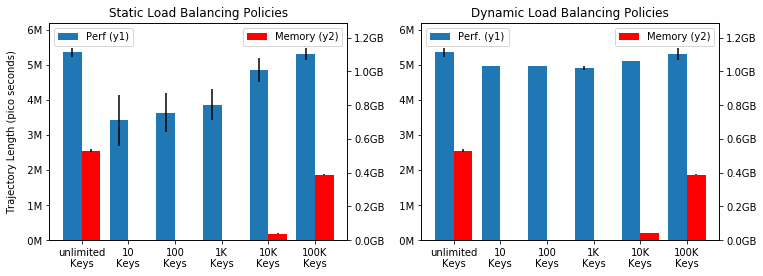

In [11]:
def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.head(int(len(df)*0.6)).tail(1)

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.head(int(len(df)*0.6)).tail(1)

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"),           
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004"),               
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

fig, axis = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.25)
ax = axis[0]
ax.set_title("Static Load Balancing Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, width=0.4, label="Perf (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylabel("Trajectory Length (pico seconds)")
ax.legend(loc='upper left')
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72376"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72373",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = axis[1]
ax.set_title("Dynamic Load Balancing Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, width=0.4, label="Perf. (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
#ax.set_ylabel("Trajectory Length (pico seconds)")
ax.legend(loc='upper left')
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])

fig.savefig("../paper/figures/methodology-tradeoff.png", bbox_inches='tight', dpi=400)

Why does this work? 

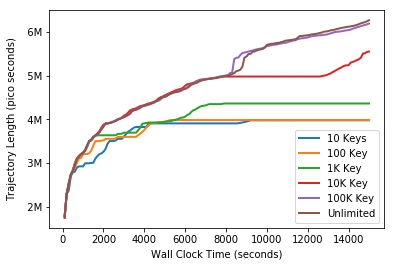

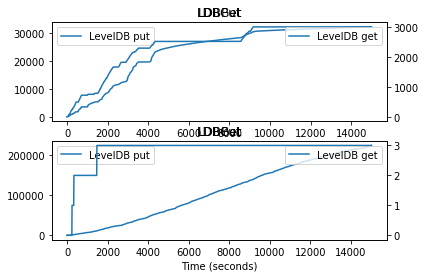

In [187]:
fig, ax = plt.subplots(1, 1)
plot_times(ax, "10 Keys", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989")
plot_times(ax, "100 Key", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990")
plot_times(ax, "1K Key",  d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991")
plot_times(ax, "10K Key", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004")
plot_times(ax, "100K Key", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005")
plot_times(ax, "Unlimited", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000")
ax.legend()
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    if label == "":
        label = os.path.basename(results).split('-')[2] + " Nodes"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend()
    
fig, ax = plt.subplots(2, 1)
plot_keyspace(ax[0], "LDBPut", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989", rank="2", label="LevelDB put")
plot_keyspace(ax[0].twinx(), "LDBGet", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989", rank="2", label="LevelDB get")
plot_keyspace(ax[1], "LDBPut", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000", rank="2", label="LevelDB put")
plot_keyspace(ax[1].twinx(), "LDBGet", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000", rank="2", label="LevelDB get")
#ax[0].set_xlim(0, 1000)
#ax[0].set_ylim(0, 400)
#ax[1].set_xlim(0, 1000)
#ax[1].set_ylim(0, 400)

## Future Work: Use Machine Learning to Change Policies
Keyspace access and keys looks structured although squished depending on the parameters.

1. Keyspace has structured workload that we can learn what phase we are in
2. We can predict how big the keypsace is because of HPC
3. Feedback loops to create a control system


In [5]:
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... done: " + os.path.basename(results)
    return stats

In [6]:
dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Node, 100K", d+"nano-sepminima/scale-keyspace-trace/scale-workers-4-71541/"))
stats.append(parse(dfs, "4 Node, 1M",   d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-4-71537/"))
stats.append(parse(dfs, "1 Node, 100K", d+"nano-sepminima/scale-keyspace-trace/scale-workers-1-71538"))

... done: 
... done: 
... done: scale-workers-1-71538


In [7]:
stats.append(parse(dfs, "1 Node, 1M", d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-1-71684"))

... done: scale-workers-1M-1-71684


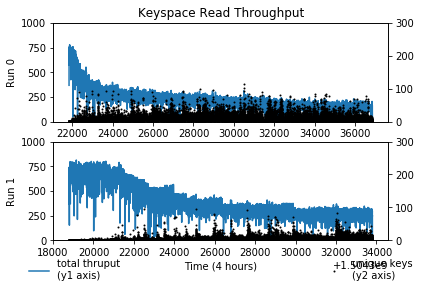

In [73]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="total thruput\n(y1 axis)")
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=1, label="unique keys\n(y2 axis)")
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 300)
    return ax2

fig, ax = plt.subplots(2, 1)#, figsize=(20, 4))
#fig.subplots_adjust(hspace=.5)
plot_uniquekeys_per_ts(ax[0], dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
ax2 = plot_uniquekeys_per_ts(ax[1], dfs, ("4 Node, 1M", "DBMemoryGet", "4"))
#plot_uniquekeys_per_ts(ax[2], dfs, ("1 Node, 1M", "DBMemoryGet", "4"))

ax[0].set_xlabel("")
for i in range(0, len(ax)):
    #ax[i].set_xticklabels([])
    #ax[i].set_xticks([])
    ax[i].set_ylim(0, 1000)
ax[1].set_xlabel("Time (4 hours)")
ax[1].legend(bbox_to_anchor=(-0.1, -0.5), loc='lower left', frameon=False)
ax2.legend(bbox_to_anchor=(1.1, -0.5), loc='lower right', frameon=False)
ax[0].set_title("Keyspace Read Throughput")
ax[0].set_ylabel("Run 0")
ax[1].set_ylabel("Run 1")
#ax[2].set_ylabel("1N, 1M")

#fig.savefig("../paper/figures/motivation-regimes.png", bbox_inches='tight', dpi=400)

(0, 1000)

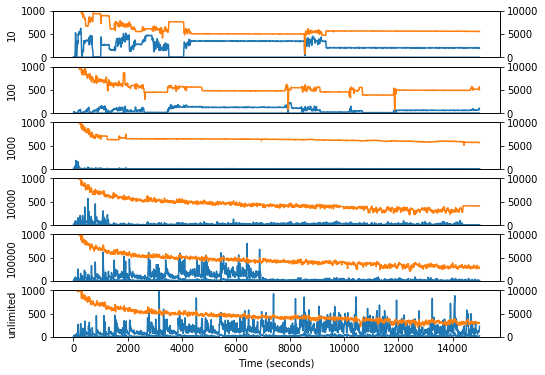

In [148]:
def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    ax.plot(df['ts'].astype(float) - shift, df['cs'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.legend
    
def plot_keyspace_activity(ax, results):
    plot_keyspace(ax, "DBMemoryMapSize", results)
    ax2 = ax.twinx()
    plot_keyspace(ax2, "DBMemoryPut", results)
    plot_keyspace(ax2, "DBMemoryGet", results)
    ax.set_ylabel(os.path.basename(results).split('-')[3])
    ax2.set_ylim(0, 10000)
    
fig, ax = plt.subplots(6, 1, figsize=(8, 6))
plot_keyspace_activity(ax[0], d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989")
plot_keyspace_activity(ax[1], d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002")
plot_keyspace_activity(ax[2], d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003")
plot_keyspace_activity(ax[3], d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992")
plot_keyspace_activity(ax[4], d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993")
plot_keyspace_activity(ax[5], d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")

for i in range(0, len(ax)-1):
    ax[i].set_ylim(0, 1000)
    ax[i].set_xlabel("")
    ax[i].set_xticks([])    
ax[len(ax)-1].set_ylim(0, 1000)

## Extra Graphs


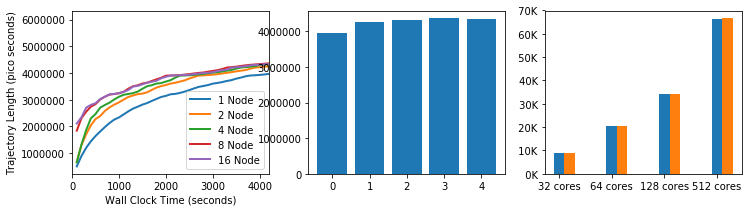

In [9]:

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
d = "../experiments/baseline-trinitite/"
plot_times(ax[0], "1 Node", d+"nano-sepminima/scale-workers-1to8n/scale-workers-1-71033")
plot_times(ax[0], "2 Node", d+"nano-sepminima/scale-workers-1to8n/scale-workers-2-71035")
plot_times(ax[0], "4 Node", d+"nano-sepminima/scale-workers-1to8n/scale-workers-4-71036")
plot_times(ax[0], "8 Node", d+"nano-sepminima/scale-workers-1to8n/scale-workers-8-71057")
plot_times(ax[0], "16 Node", d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161")
ax[0].set_xlim(0, 4200)

def read_df(results):
    if os.path.exists(results + "/times.out"):
        return pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        return pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    
def get_nth_traj(results, n):
    df = read_df(results)
    df = df[df['wc']==n]
    return df
def get_max_traj(results):
    return read_df(results).tail(1)

trajs = []
for run in [d+"nano-sepminima/scale-workers-1to8n/scale-workers-1-71033",
            d+"nano-sepminima/scale-workers-1to8n/scale-workers-2-71035",
            d+"nano-sepminima/scale-workers-1to8n/scale-workers-4-71036",
            d+"nano-sepminima/scale-workers-1to8n/scale-workers-8-71057"]:
    df = get_max_traj(run)
    trajs.append(df['traj'])
    
for run in [d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161"]:
    df = get_nth_traj(run, 4200)
    trajs.append(df['traj'])
    
ax[1].bar(range(0, len(trajs)), trajs)



#### Figure 1
InMemoryDB = []; WorkManager = []; label = []
for run in [d+"nano-sepminima/scale-workers-1to8n/scale-workers-1-71033",
            d+"nano-sepminima/scale-workers-1to8n/scale-workers-2-71035",
            d+"nano-sepminima/scale-workers-1to8n/scale-workers-4-71036"]:
    df = get_perfcount("DBMemoryMapSize", run, rank="3")
    InMemoryDB.append(df.tail(1)['count'])    
    
    df = get_perfcount("DBMemoryMapSize", run)
    WorkManager.append(df.tail(1)['count'])
    
    label.append(str(int(os.path.basename(run).split('-')[2])*32) + " cores")
    
df = get_perfcount("DBMemoryMapSize", d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161", rank="3")
df = df[df['shift']==4200]
InMemoryDB.append(df['count'])
df = get_perfcount("DBMemoryMapSize", d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161")
df = df[df['shift']==4200]
WorkManager.append(df['count'])
label.append("512 cores")

#fig, ax = plt.subplots(1, 1)
ax = ax[2]
ax.bar(np.arange(len(InMemoryDB)), InMemoryDB, width=0.2)
ax.bar(np.arange(len(WorkManager)) + 0.2, WorkManager, width=0.2)

ax.set_xticks(range(0, len(label)))
ax.set_xticklabels(label)
x = ax.set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax.get_yticks()])

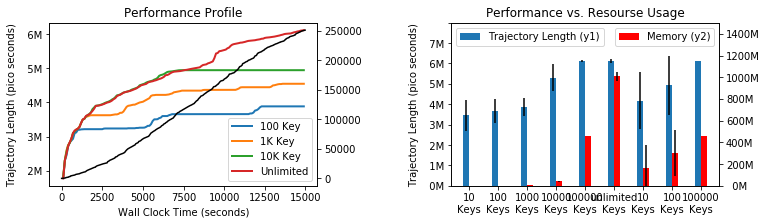

In [10]:
def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.tail(1)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
fig.subplots_adjust(wspace=0.5)
d = "../experiments/baseline-trinitite/"
#plot_times(ax[0], "1 Key",   d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1-71233")
plot_times(ax[0], "100 Key", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-100-71234")
plot_times(ax[0], "1K Key",  d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1000-71235")
plot_times(ax[0], "10K Key", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-10000-71236")
plot_times(ax[0], "Unlimited", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax[0].legend()
ax[0].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[0].get_yticks()])


def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)

trajs = []; terror = []
label = []
memory = []; merror = []
#for run in [d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1-71233",
#            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-100-71234",
#            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-1000-71235",
#            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-10000-71236",
#            d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237"]:
#    trajs.append(float(get_max_traj(run)['traj']))
#    terror.append(0)
#    memory.append(float(get_max_op("DBMemorySize", run)['count']))
#    merror.append(0)
#    label.append(os.path.basename(run).split('-')[3] + "\nKey")
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001"
             ),
             (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"
             ),
             (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"
             ),
             (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004",
             ),
             (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005"
             ),
             (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006",
             ),
            (d+"nano-sepminima/scale-mantle-workers/scale-mantle-10-71702",
            d+"nano-sepminima/scale-mantle-workers/scale-mantle-10-71706",
            d+"nano-sepminima/scale-mantle-workers/scale-mantle-10-71710"),
            (d+"nano-sepminima/scale-mantle-workers/scale-mantle-100-71703",
            d+"nano-sepminima/scale-mantle-workers/scale-mantle-100-71707",
            d+"nano-sepminima/scale-mantle-workers/scale-mantle-100-71711"),
            (d+"nano-sepminima/scale-mantle-workers/scale-mantle-100000-71704",
            d+"nano-sepminima/scale-mantle-workers/scale-mantle-100000-71708",
            d+"nano-sepminima/scale-mantle-workers/scale-mantle-100000-71712"),
           ]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[2]
    if l == "8n": l = os.path.basename(run).split('-')[3]
    l += "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax[0].set_title("Performance Profile")
df = get_perfcount("DBMemoryMapSize", d+"nano/scale-workers-and-delay/scale-cachelimit-8n-unlimited-71237")
ax2 = ax[0].twinx()
ax2.plot(df['shift'], df['count'], color='black')  
#ax2.set_ylim(0, 30000)

ax[1].set_title("Performance vs. Resourse Usage")
ax[1].bar(np.arange(len(trajs)) - 0.1, trajs, yerr=terror, width=0.2, label="Trajectory Length (y1)")
ax[1].set_xticks(range(0, len(trajs)))
ax[1].set_xticklabels(label)
ax[1].set_ylabel("Trajectory Length (pico seconds)")
ax[1].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
ax[1].legend(loc='upper left')
ax[1].set_ylim(0, 8*1000*1000)
ax2 = ax[1].twinx()
ax2.bar(np.arange(len(memory)) + 0.1, memory, yerr=merror, width=0.2, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.set_xticklabels(label)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.4*1024*1024*1024)

x = ax2.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax2.get_yticks()])

## OMG does this work?

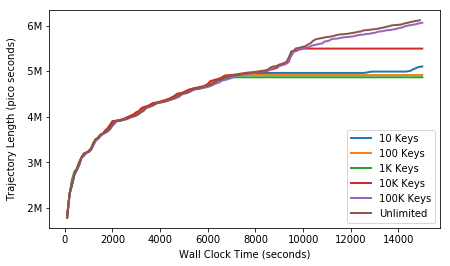

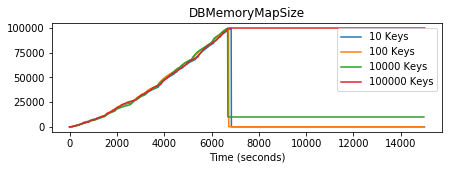